### The_navigation information_of_the_identified_9_paths_at_Regensburg_Budapest_corridor_at Medium Water Level(MWL) condition 
- routes with origin and destination, including sailing directions
- water depth per stretch
- current speed per stretch
- vessel operation details (speed) along the routes (per stretch)

In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages


### create graph with navigation info

In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.4042418779,0],
    [0.79950060287,0], 
    [1.10492779947,0],
    [1.25764139777,0],
    [1.27560770345,0],
    [1.527135983,0],
    [1.69781588699,0], 
    [2.03019254211,0],
    [2.16493983473,0],
    [2.34460289155,0],
    [3.0093562018,0],
    [3.27885078704,0], 
    [3.36868231545,0],
    [4.06038508422,0],
    [4.06936823706,0], 
    [4.4915764206,0],
    [4.54547533765,0],
    [4.68022263026,0], 
    [5.04853189675,0],
    [5.2102286479,0],
    [5.68633574848,0],
    [6.1354933906,0],
    [6.5846510326,0], 
] 


# for each edge (between above coordinates) specify the depth (m)
depths = [
            7.5, 4.18, 4.18, 7.83,7.83, 
            7.5, 6.5, 10.6, 6.45, 8.04,
            8.04, 5.65, 8.87, 8.87, 4.93,
            4.93, 7.7,7.7, 9.8, 5.45, 5.45, 5.45, 5.45
         ] # [m]

current_speeds = [
                    -2.24* 0.2777, -3.4* 0.2777, -4.93* 0.2777, -2.59* 0.2777, -2.59* 0.2777,
                    -3.26* 0.2777, -3.85* 0.2777, -1.87* 0.2777, -1.08* 0.2777, -2.83* 0.2777, 
                    -2.83* 0.2777, -4.99* 0.2777,  -2.89* 0.2777,  -2.89* 0.2777, -6.4* 0.2777,
                    -6.4* 0.2777, -3.42* 0.2777, -3.42* 0.2777, -1.64* 0.2777, -4.1* 0.2777, -4.1* 0.2777, -4.1* 0.2777, -4.1* 0.2777
                ]  # [m/s]

V_g_profile_up = [
                    3.33, 3.33, 3.33, 3.33, 3.33,   
                    3.33, 3.33, 3.33, 3.33, 3.33,
                    3.33, 3.33, 3.33, 3.33, 3.33,
                    3.33, 3.33, 3.33, 3.33, 3.33, 3.33,3.33, 3.33
                ] # [m/s] for upstream, 3.33 m/s = 12 km/h

V_g_profile_down = [
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 3.33, 4.44, 4.44,4.44, 4.44
                    ] # [m/s] for downstream, 4.44 m/s = 16 km/h


# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile_upstream": V_g_profile_up[index],
        "VesselSpeedToGroundProfile_downstream": V_g_profile_down[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

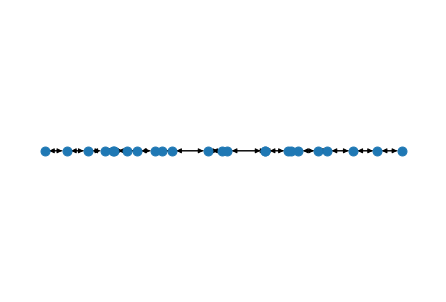

In [4]:
# show graph
nx.draw(FG, positions, node_size=80)

plt.show()

In [5]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {} m'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))
    print('Current speed for edge {} is {} m/s'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["CurrentSpeed"]))
    print('Vessel Speed To Ground for edge {} is {} m/s while sailing upstream'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["VesselSpeedToGroundProfile_upstream"]))
    print('Vessel Speed To Ground for edge {} is {} m/s while sailing downstream'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["VesselSpeedToGroundProfile_downstream"]))

General depth for edge ('Node 0', 'Node 1') is 7.5 m
Current speed for edge ('Node 0', 'Node 1') is -0.622048 m/s
Vessel Speed To Ground for edge ('Node 0', 'Node 1') is 3.33 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 0', 'Node 1') is 4.44 m/s while sailing downstream
General depth for edge ('Node 1', 'Node 0') is 7.5 m
Current speed for edge ('Node 1', 'Node 0') is -0.622048 m/s
Vessel Speed To Ground for edge ('Node 1', 'Node 0') is 3.33 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 1', 'Node 0') is 4.44 m/s while sailing downstream
General depth for edge ('Node 1', 'Node 2') is 4.18 m
Current speed for edge ('Node 1', 'Node 2') is -0.94418 m/s
Vessel Speed To Ground for edge ('Node 1', 'Node 2') is 3.33 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 1', 'Node 2') is 4.44 m/s while sailing downstream
General depth for edge ('Node 2', 'Node 1') is 4.18 m
Current speed for edge ('Node 2', 'Node 1') is -0.94418 m/s
Vessel Spe

### define the 9 sailing paths on the graph for energy use simulation

In [6]:
path_up_1_Budapest2Regensburg = nx.dijkstra_path(FG, nodes[23].name, nodes[0].name)
path_up_2_Budapest2Linz = nx.dijkstra_path(FG, nodes[23].name, nodes[9].name)
path_up_3_Budapest2Bratislava = nx.dijkstra_path(FG, nodes[23].name, nodes[17].name)
path_up_4_Bratislava2Linz = nx.dijkstra_path(FG, nodes[17].name, nodes[9].name)
path_up_5_Linz2Regensburg =  nx.dijkstra_path(FG, nodes[9].name, nodes[0].name)

path_down_6_Regensburg2Linz = nx.dijkstra_path(FG, nodes[0].name, nodes[9].name)
path_down_7_Regensburg2Budapest = nx.dijkstra_path(FG, nodes[0].name, nodes[23].name)
path_down_8_Linz2Budapest =  nx.dijkstra_path(FG, nodes[9].name, nodes[23].name)
path_down_9_Bratislava2Budapest = nx.dijkstra_path(FG, nodes[17].name, nodes[23].name)


In [7]:
path_up_1_Budapest2Regensburg

['Node 23',
 'Node 22',
 'Node 21',
 'Node 20',
 'Node 19',
 'Node 18',
 'Node 17',
 'Node 16',
 'Node 15',
 'Node 14',
 'Node 13',
 'Node 12',
 'Node 11',
 'Node 10',
 'Node 9',
 'Node 8',
 'Node 7',
 'Node 6',
 'Node 5',
 'Node 4',
 'Node 3',
 'Node 2',
 'Node 1',
 'Node 0']

In [8]:
path_down_8_Linz2Budapest

['Node 9',
 'Node 10',
 'Node 11',
 'Node 12',
 'Node 13',
 'Node 14',
 'Node 15',
 'Node 16',
 'Node 17',
 'Node 18',
 'Node 19',
 'Node 20',
 'Node 21',
 'Node 22',
 'Node 23']